In [ ]:
!pip install python-igraph pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d stackoverflow/stacksample --unzip

Dataset URL: https://www.kaggle.com/datasets/stackoverflow/stacksample
License(s): other


In [ ]:
import pandas as pd

# Load the datasets
questions = pd.read_csv("Questions.csv", encoding='ISO-8859-1')
tags = pd.read_csv("Tags.csv", encoding='ISO-8859-1')

# Display the first few rows
print("Questions:")
print(questions.head())

print("\nTags:")
print(tags.head())

Questions:
    Id  OwnerUserId          CreationDate            ClosedDate  Score  \
0   80         26.0  2008-08-01T13:57:07Z                   NaN     26   
1   90         58.0  2008-08-01T14:41:24Z  2012-12-26T03:45:49Z    144   
2  120         83.0  2008-08-01T15:50:08Z                   NaN     21   
3  180    2089740.0  2008-08-01T18:42:19Z                   NaN     53   
4  260         91.0  2008-08-01T23:22:08Z                   NaN     49   

                                               Title  \
0  SQLStatement.execute() - multiple queries in o...   
1  Good branching and merging tutorials for Torto...   
2                                  ASP.NET Site Maps   
3                 Function for creating color wheels   
4  Adding scripting functionality to .NET applica...   

                                                Body  
0  <p>I've written a database generation script i...  
1  <p>Are there any really good tutorials explain...  
2  <p>Has anyone got experience creating <

In [ ]:
# Select relevant columns
questions = questions[['Id', 'Title']]
tags = tags[['Id', 'Tag']]

In [ ]:
# Merge questions with tags
merged = pd.merge(tags, questions, on='Id', how='inner')

# Group by question ID and aggregate tags into lists
tag_groups = merged.groupby(['Id', 'Title'])['Tag'].apply(list).reset_index()

# Display the merged data
print("\nMerged Data with Tags:")
print(tag_groups.head())


Merged Data with Tags:
    Id                                              Title  \
0   80  SQLStatement.execute() - multiple queries in o...   
1   90  Good branching and merging tutorials for Torto...   
2  120                                  ASP.NET Site Maps   
3  180                 Function for creating color wheels   
4  260  Adding scripting functionality to .NET applica...   

                                                 Tag  
0                        [flex, actionscript-3, air]  
1  [svn, tortoisesvn, branch, branching-and-merging]  
2                            [sql, asp.net, sitemap]  
3  [algorithm, language-agnostic, colors, color-s...  
4       [c#, .net, scripting, compiler-construction]  


In [ ]:
# Cleaning the tags
# Convert all tags to strings and handle NaN values
tag_groups['Tag'] = tag_groups['Tag'].apply(lambda x: [str(tag) for tag in x if isinstance(tag, str)])

In [ ]:
from collections import defaultdict
import itertools

# Create edges
edges = defaultdict(int)

# Iterate through each question's tags and create pairs
for tags in tag_groups['Tag']:
    for combo in itertools.combinations(tags, 2):
        edge = tuple(sorted(combo))  # Sort to avoid duplicates
        edges[edge] += 1

# Convert the edge dictionary to a list of tuples
edge_list = [(src, dst, weight) for (src, dst), weight in edges.items()]

print(f"Total edges: {len(edge_list)}")

Total edges: 915047


In [ ]:
from igraph import Graph

# Extract unique nodes
nodes = list(set([tag for tags in tag_groups['Tag'] for tag in tags]))

# Create the graph
g = Graph()

# Add nodes
g.add_vertices(nodes)

# Add edges with weights
g.add_edges([(src, dst) for src, dst, _ in edge_list])
g.es['weight'] = [weight for _, _, weight in edge_list]

print(g.summary())

IGRAPH UNW- 37034 915047 -- 
+ attr: name (v), weight (e)


In [ ]:
# Degree centrality
degrees = g.degree()
g.vs['degree'] = degrees

# Betweenness centrality
betweenness = g.betweenness()
g.vs['betweenness'] = betweenness

# Closeness centrality
closeness = g.closeness()
g.vs['closeness'] = closeness

# Print top 5 tags by degree centrality
top_tags = sorted(zip(g.vs['name'], degrees), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Tags by Degree Centrality:")
for tag, deg in top_tags:
    print(f"{tag}: {deg}")

KeyboardInterrupt: 

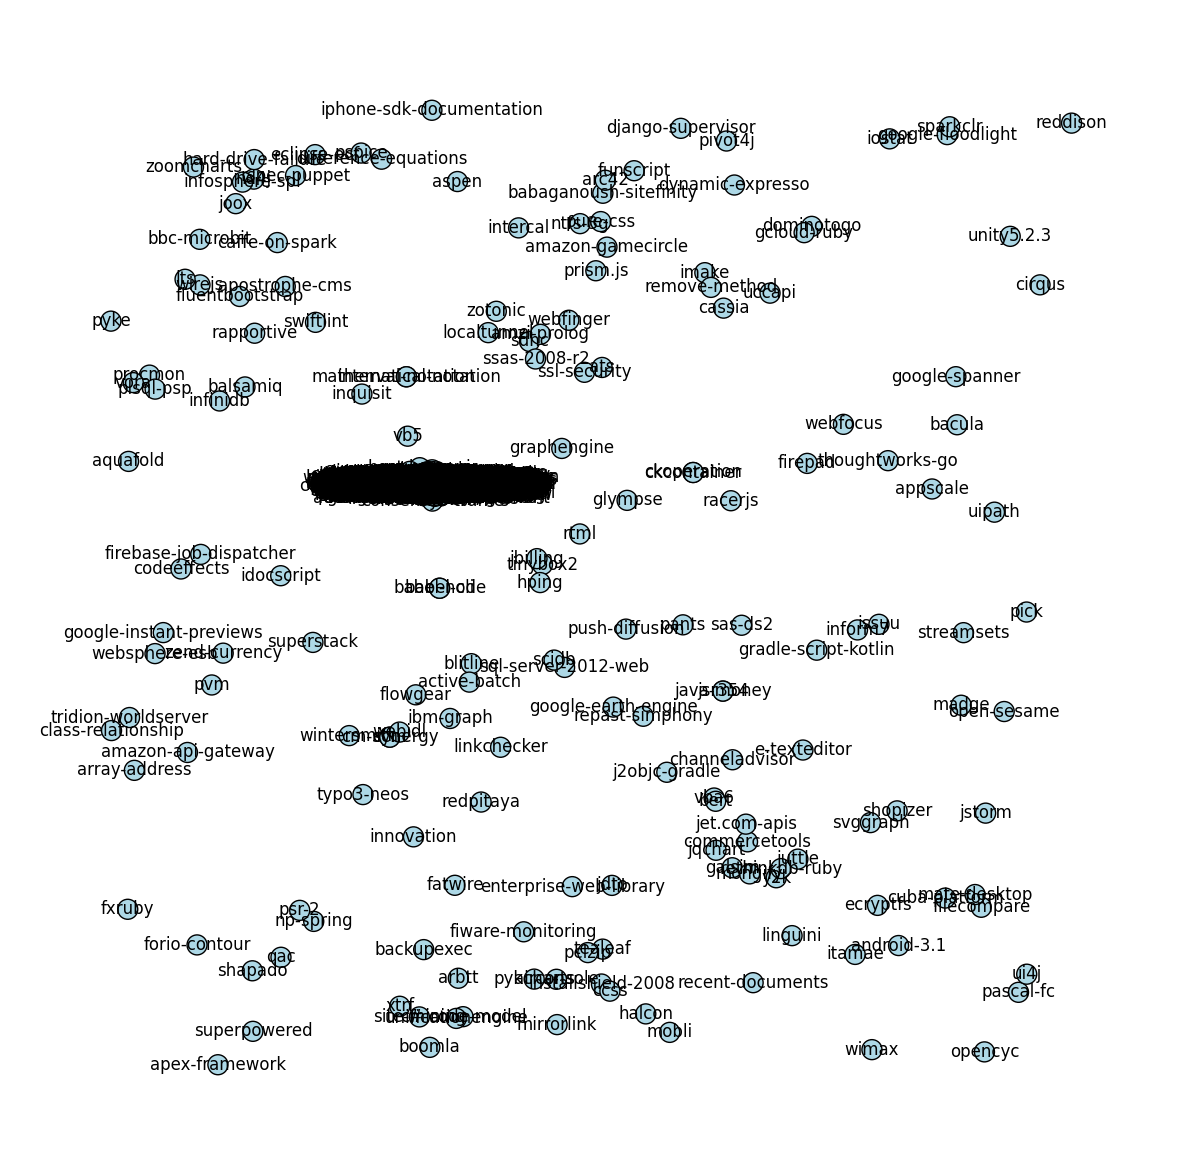

In [ ]:
import matplotlib.pyplot as plt
from igraph import plot

# Layout options: "fruchterman_reingold", "kamada_kaway", "circle"
layout = g.layout("fruchterman_reingold")

# Plot the graph
fig, ax = plt.subplots(figsize=(15, 15))
ig_plot = plot(
    g,
    target=ax,
    layout=layout,
    vertex_size=20,
    vertex_label=g.vs['name'],
    vertex_color='lightblue',
    # edge_width=[w / max(g.es['weight']) * 5 for w in g.es['weight']]
)
plt.show()